This notebook shows and analyzes the results of the main experiment.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, scipy, time, warnings
from sklearn.metrics import r2_score, log_loss,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, classification_report

In [3]:
from methods.utils import CB_color_cycle, ORDER, colors, METRIC_MAPPER

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
import warnings
warnings.filterwarnings('ignore') #avoid LGBM categorical feature warnings

# Load data

In [6]:
metrics = ['accuracy', 'roc_auc', 'f1']

In [7]:
# dataset with the results
df = pd.read_parquet('experiment_results/experiment_results.pq')

In [8]:
df['method'].value_counts()

TEST_SET    59365
DOC         59365
CBPE        59365
IW          59365
RT          59365
PAPE        59365
ATC         59365
Name: method, dtype: int64

In [9]:
df.head()

,method,dataset,monitored_model,accuracy,est_accuracy,roc_auc,est_roc_auc,f1,est_f1,period,chunksize,step
0,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.787,0.791343,0.872960,0.875932,0.745823,0.756089,reference,2000,2000
1,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.794,0.791343,0.879778,0.875932,0.757075,0.756089,reference,2000,2000
2,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.790,0.791343,0.871443,0.875932,0.764574,0.756089,reference,2000,2000
3,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.781,0.791343,0.868667,0.875932,0.744457,0.756089,transition,2000,2000
4,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.784,0.791343,0.865775,0.875932,0.753986,0.756089,production,2000,2000


In [10]:
# data with standard deviations/standard errors per evaluation case
stds = pd.read_parquet('experiment_results/STD_results.pq') 
stds['evaluation_case'] = stds[['dataset', 'client_model']].astype(str).agg('-'.join, axis=1)
stds = stds[['evaluation_case', 'std_accuracy', 'std_roc_auc','std_f1']]

In [11]:
all_methods = list(df['method'].unique())


In [12]:
df['evaluation_case'] = df[['dataset', 'monitored_model']].astype(str).agg('-'.join, axis=1)

In [13]:
df = pd.merge(df, stds, on='evaluation_case') 

In [14]:
df.head()

,method,dataset,monitored_model,accuracy,est_accuracy,roc_auc,est_roc_auc,f1,est_f1,period,chunksize,step,evaluation_case,std_accuracy,std_roc_auc,std_f1
0,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.787,0.791343,0.872960,0.875932,0.745823,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545
1,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.794,0.791343,0.879778,0.875932,0.757075,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545
2,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.790,0.791343,0.871443,0.875932,0.764574,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545
3,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.781,0.791343,0.868667,0.875932,0.744457,0.756089,transition,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545
4,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.784,0.791343,0.865775,0.875932,0.753986,0.756089,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545


## Preprocess: Remove dataset with less than 3 reference chunks

In [15]:
n = 3
df_ref = df[df['period']=='reference']
reference_chunks = df_ref.groupby(['method','evaluation_case'])['accuracy'].count().reset_index().sort_values('accuracy')
datasets_with_less_than_n_chunks = reference_chunks[reference_chunks['accuracy']<n]['evaluation_case'].unique()
df = df[~df['evaluation_case'].isin(list(datasets_with_less_than_n_chunks))].reset_index(drop=True)

len(df)

407785

## Preprocess: Remove random/bad performing models

Remove models with reference performance worse than: auroc<=0.5, f1==0.

In [16]:
ref_performance = df[df['method']=='TEST_SET']
uq_datesets_to_drop = ref_performance[ref_performance['est_roc_auc']<=0.5]['evaluation_case'].unique()

df = df[~df['evaluation_case'].isin(uq_datesets_to_drop)].reset_index(drop=True)

ref_performance = df[df['method']=='TEST_SET']
uq_datesets_to_drop = ref_performance[ref_performance['est_f1']==0]['evaluation_case'].unique()

df = df[~df['evaluation_case'].isin(uq_datesets_to_drop)].reset_index(drop=True)

df['evaluation_case'].nunique()

959

In [17]:
df['method'].value_counts()

TEST_SET    55732
DOC         55732
CBPE        55732
IW          55732
RT          55732
PAPE        55732
ATC         55732
Name: method, dtype: int64

## Preprocess: add Constant Corrected Reverse Training

As described in the paper, for Reverse Training we apply constant correction so that the performance estimated by this method on reference data (where labels are available) matches, on average, the realized performance. Otherwise the estimates were biased and uncomparable to other methods. We keep the original method for investigation.

In [18]:
RT = df[df['method']=='RT']
RT_ref = RT[RT['period']=='reference'].copy()

RT_corrected = RT.copy()
for metric in metrics:
    RT_ref[metric + '_diff_on_reference'] = RT_ref[metric] - RT_ref['est_' + metric] # difference between realized and estimated on reference chunks
    constant_correction_for_RT = RT_ref.groupby('evaluation_case')[metric + '_diff_on_reference'].mean().reset_index(drop=False) # get mean difference per evaluation case
    RT_corrected = pd.merge(RT_corrected, constant_correction_for_RT, left_on='evaluation_case', right_on='evaluation_case')
    RT_corrected['est_' + metric] = RT_corrected['est_' + metric] + RT_corrected[metric + '_diff_on_reference']
    RT_corrected = RT_corrected.drop(columns=[metric + '_diff_on_reference'])

RT_corrected['method'] = 'RT-mod'
df = pd.concat([df, RT_corrected]).reset_index(drop=True)

In [19]:
df.groupby('method')['method'].count()

method
ATC         55732
CBPE        55732
DOC         55732
IW          55732
PAPE        55732
RT          55732
RT-mod      55732
TEST_SET    55732
Name: method, dtype: int64

# Analyze results

In [20]:
# calculate performance changes and 3 SE thresholds.
if not 'ref_'+metric in df.columns: # to preven unfortunate double run consequences
    df_ref = df[df['period']=="reference"].copy()

    df_ref_constant = df_ref[df_ref['method']=="TEST_SET"]

    for metric in ['accuracy', 'roc_auc', 'f1']:
        metric_std = df_ref_constant.groupby(['evaluation_case'])['std_' + metric].max().rename(metric)#std per evaluation_case, max is used, but it really is the same.
        metric_ref = df_ref_constant.groupby(['evaluation_case'])['est_' + metric].max().rename(metric)#ref perf for evaluation_case, max is used, but it really is the same.

        upper_thr = metric_ref + 3*metric_std
        upper_thr = upper_thr.reset_index().rename(columns={metric:'up_' + metric})
        lower_thr = metric_ref - 3*metric_std
        lower_thr = lower_thr.reset_index().rename(columns={metric:'low_' + metric})
        ref_metric = metric_ref.reset_index().rename(columns={metric:'ref_' + metric})
        std_ref = metric_std.reset_index().rename(columns={metric:'std_' + metric})
        df = pd.merge(df, upper_thr, left_on='evaluation_case', right_on='evaluation_case')
        df = pd.merge(df, lower_thr, left_on='evaluation_case', right_on='evaluation_case')

        df = pd.merge(df, ref_metric, left_on='evaluation_case', right_on='evaluation_case')
        df[metric+'_change'] = df[metric] - df['ref_'+metric]
        df[metric+'_est_change'] = df['est_'+metric] - df['ref_'+metric]
        df[metric+'_std_change'] = df[metric+'_change']/df['std_' + metric]
        df[metric+'_est_std_change'] = df[metric+'_est_change']/df['std_' + metric]

In [21]:
df.head()

,method,dataset,monitored_model,accuracy,est_accuracy,roc_auc,est_roc_auc,f1,est_f1,period,chunksize,step,evaluation_case,std_accuracy,std_roc_auc,std_f1,up_accuracy,low_accuracy,ref_accuracy,accuracy_change,accuracy_est_change,accuracy_std_change,accuracy_est_std_change,up_roc_auc,low_roc_auc,ref_roc_auc,roc_auc_change,roc_auc_est_change,roc_auc_std_change,roc_auc_est_std_change,up_f1,low_f1,ref_f1,f1_change,f1_est_change,f1_std_change,f1_est_std_change
0,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.787,0.791343,0.872960,0.875932,0.745823,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.004343,0.0,-0.577153,0.0,0.895105,0.85676,0.875932,-0.002972,0.0,-0.465023,0.0,0.784723,0.727455,0.756089,-0.010266,0.0,-1.075556,0.0
1,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.794,0.791343,0.879778,0.875932,0.757075,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,0.002657,0.0,0.353176,0.0,0.895105,0.85676,0.875932,0.003846,0.0,0.601814,0.0,0.784723,0.727455,0.756089,0.000986,0.0,0.103333,0.0
2,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.790,0.791343,0.871443,0.875932,0.764574,0.756089,reference,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.001343,0.0,-0.178441,0.0,0.895105,0.85676,0.875932,-0.004489,0.0,-0.702439,0.0,0.784723,0.727455,0.756089,0.008485,0.0,0.888959,0.0
3,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.781,0.791343,0.868667,0.875932,0.744457,0.756089,transition,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.010343,0.0,-1.374577,0.0,0.895105,0.85676,0.875932,-0.007265,0.0,-1.136716,0.0,0.784723,0.727455,0.756089,-0.011632,0.0,-1.218671,0.0
4,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.784,0.791343,0.865775,0.875932,0.753986,0.756089,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.007343,0.0,-0.975865,0.0,0.895105,0.85676,0.875932,-0.010157,0.0,-1.589271,0.0,0.784723,0.727455,0.756089,-0.002103,0.0,-0.220318,0.0


In [22]:
dfa = df[df['period']=='production'].copy() # Production period that is subject to analysis

In [23]:
len(dfa) # Production data chunks per evaluated method

293400

In [24]:
dfa['method'].value_counts() # Production chunks per method

TEST_SET    36675
DOC         36675
CBPE        36675
IW          36675
RT          36675
PAPE        36675
ATC         36675
RT-mod      36675
Name: method, dtype: int64

## MAE and RMSE

Calculate standard regression metrics first. Even though they're not relevant (for the reasons explained in the paper).

In [25]:
dfa['monitored_model'].value_counts() 
# Production chunks per monitored model. Most chunks were dropped for FT_Transformer (mainly due to low performing models)

LogisticRegression_        61336
LGBMClassifier_            61336
RandomForestClassifier_    61336
XGB_                       61336
FT_Transformer_            48056
Name: monitored_model, dtype: int64

In [26]:
for metric in metrics:
    dfa['AE_' + metric] = abs(dfa[metric]-dfa['est_' + metric])
    dfa['SE_' + metric] = (dfa[metric]-dfa['est_' + metric])**2
    df_ref['AE_' + metric] = abs(df_ref[metric]-df_ref['est_' + metric])
    df_ref['SE_' + metric] = (df_ref[metric]-df_ref['est_' + metric])**2
                              

In [27]:
# Expressed in metric value
res = pd.DataFrame()

for metric in ['accuracy', 'roc_auc', 'f1']:
    for method_name, method_data in dfa.groupby('method'):
        MAE = np.mean(method_data['AE_' + metric])
        res.loc[method_name, metric + ' MAE'] = MAE
    for method_name, method_data in dfa.groupby('method'):
        RMSE = np.sqrt(np.mean(method_data['SE_' + metric]))
        res.loc[method_name, metric + '  RMSE'] = RMSE

In [28]:
table_1 = res.copy()

In [29]:
(table_1.round(4)).reindex(ORDER)

,accuracy MAE,accuracy RMSE,roc_auc MAE,roc_auc RMSE,f1 MAE,f1 RMSE
TEST_SET,0.0143,0.0258,0.0124,0.0198,0.0283,0.0840
RT-mod,0.0202,0.0470,0.0156,0.0330,0.0231,0.0469
ATC,0.0141,0.0254,0.0173,0.0341,0.0355,0.0996
DOC,0.0100,0.0164,0.0117,0.0222,0.0293,0.0893
CBPE,0.0096,0.0161,0.0093,0.0145,0.0123,0.0229
IW,0.0091,0.0123,0.0092,0.0135,0.0134,0.0218
PAPE,0.0085,0.0113,0.0085,0.0125,0.0110,0.0164


In [30]:
TEST_SET_SCORES = table_1.loc['TEST_SET',:]

In [31]:
TEST_SET_SCORES = TEST_SET_SCORES.round(3)

In [32]:
TEST_SET_SCORES

accuracy MAE      0.014
accuracy  RMSE    0.026
roc_auc MAE       0.012
roc_auc  RMSE     0.020
f1 MAE            0.028
f1  RMSE          0.084
Name: TEST_SET, dtype: float64

In [33]:
relative_to_constant = (table_1/table_1.loc['TEST_SET',:]).round(2)

In [34]:
relative_to_constant.loc['TEST_SET'] = '1.00 (' + TEST_SET_SCORES.astype(str) + ')'

In [35]:
relative_to_constant.reindex(ORDER)

,accuracy MAE,accuracy RMSE,roc_auc MAE,roc_auc RMSE,f1 MAE,f1 RMSE
TEST_SET,1.00 (0.014),1.00 (0.026),1.00 (0.012),1.00 (0.02),1.00 (0.028),1.00 (0.084)
RT-mod,1.41,1.82,1.25,1.67,0.82,0.56
ATC,0.99,0.98,1.39,1.72,1.25,1.19
DOC,0.7,0.64,0.95,1.12,1.03,1.06
CBPE,0.67,0.62,0.75,0.73,0.43,0.27
IW,0.64,0.48,0.74,0.68,0.47,0.26
PAPE,0.6,0.44,0.69,0.63,0.39,0.2


## MASTE and RMSSTE

Paper TABLE 1 results: expressed in standard error (MASTE, RMSSTE)

In [36]:
for metric in metrics:
    dfa['ASTE_'+metric] = dfa['AE_' + metric]/dfa['std_' + metric]
    dfa['SSTE_'+metric] = dfa['SE_' + metric]/dfa['std_' + metric]**2

In [37]:
res = pd.DataFrame()

for metric in metrics:
    for method_name, method_data in dfa.groupby('method'):
        MASTE = np.mean(method_data['ASTE_'+metric])
        res.loc[method_name, metric + ' MASTE'] = MASTE
    for method_name, method_data in dfa.groupby('method'):
        RMSSTE = np.sqrt(np.mean(np.mean(method_data['SSTE_'+metric])))
        res.loc[method_name, metric + '  RMSSTE'] = RMSSTE

In [38]:
TABLE_PAPER = res.copy()

In [39]:
TABLE_PAPER.reindex(ORDER).style.highlight_min(color = 'lightgreen', axis = 0)

,accuracy MASTE,accuracy RMSSTE,roc_auc MASTE,roc_auc RMSSTE,f1 MASTE,f1 RMSSTE
TEST_SET,1.623699,2.881207,1.445581,2.301804,2.525937,8.226683
RT-mod,2.305499,5.414205,1.852717,4.286039,2.060195,4.744389
ATC,1.582907,2.785869,1.899316,3.524018,2.973688,9.056271
DOC,1.129775,1.801377,1.366827,2.754424,2.560753,8.522728
CBPE,1.081655,1.747488,1.071036,1.682868,1.028937,2.120213
IW,1.037754,1.402889,1.060420,1.562759,1.072725,1.740981
PAPE,0.968775,1.282629,0.987721,1.445903,0.900342,1.344026


In [40]:
TABLE_PAPER.reindex(ORDER).round(2)

,accuracy MASTE,accuracy RMSSTE,roc_auc MASTE,roc_auc RMSSTE,f1 MASTE,f1 RMSSTE
TEST_SET,1.62,2.88,1.45,2.30,2.53,8.23
RT-mod,2.31,5.41,1.85,4.29,2.06,4.74
ATC,1.58,2.79,1.90,3.52,2.97,9.06
DOC,1.13,1.80,1.37,2.75,2.56,8.52
CBPE,1.08,1.75,1.07,1.68,1.03,2.12
IW,1.04,1.40,1.06,1.56,1.07,1.74
PAPE,0.97,1.28,0.99,1.45,0.90,1.34


### Significance test

Concatenate to make paired T-test test between all the methods

In [41]:
keep_methods = ORDER
meth_data = []

for i, (method, method_data) in enumerate(dfa.groupby('method', sort=True)):
    if ([x for x in keep_methods if x in method]):
        method_data = method_data.copy()
        method_data.columns = [method + '_' + x for x in method_data.columns]
        meth_data.append(method_data.reset_index(drop=True))
        

concatenated = pd.concat(meth_data, axis=1, ignore_index=False)

In [42]:
len(concatenated)

36675

In [43]:
concatenated.head(2)

,ATC_method,ATC_dataset,ATC_monitored_model,ATC_accuracy,ATC_est_accuracy,ATC_roc_auc,ATC_est_roc_auc,ATC_f1,ATC_est_f1,ATC_period,ATC_chunksize,ATC_step,ATC_evaluation_case,ATC_std_accuracy,ATC_std_roc_auc,ATC_std_f1,ATC_up_accuracy,ATC_low_accuracy,ATC_ref_accuracy,ATC_accuracy_change,ATC_accuracy_est_change,ATC_accuracy_std_change,ATC_accuracy_est_std_change,ATC_up_roc_auc,ATC_low_roc_auc,ATC_ref_roc_auc,ATC_roc_auc_change,ATC_roc_auc_est_change,ATC_roc_auc_std_change,ATC_roc_auc_est_std_change,ATC_up_f1,ATC_low_f1,ATC_ref_f1,ATC_f1_change,ATC_f1_est_change,ATC_f1_std_change,ATC_f1_est_std_change,ATC_AE_accuracy,ATC_SE_accuracy,ATC_AE_roc_auc,ATC_SE_roc_auc,ATC_AE_f1,ATC_SE_f1,ATC_ASTE_accuracy,ATC_SSTE_accuracy,ATC_ASTE_roc_auc,ATC_SSTE_roc_auc,ATC_ASTE_f1,ATC_SSTE_f1,CBPE_method,...,RT-mod_SSTE_f1,TEST_SET_method,TEST_SET_dataset,TEST_SET_monitored_model,TEST_SET_accuracy,TEST_SET_est_accuracy,TEST_SET_roc_auc,TEST_SET_est_roc_auc,TEST_SET_f1,TEST_SET_est_f1,TEST_SET_period,TEST_SET_chunksize,TEST_SET_step,TEST_SET_evaluation_case,TEST_SET_std_accuracy,TEST_SET_std_roc_auc,TEST_SET_std_f1,TEST_SET_up_accuracy,TEST_SET_low_accuracy,TEST_SET_ref_accuracy,TEST_SET_accuracy_change,TEST_SET_accuracy_est_change,TEST_SET_accuracy_std_change,TEST_SET_accuracy_est_std_change,TEST_SET_up_roc_auc,TEST_SET_low_roc_auc,TEST_SET_ref_roc_auc,TEST_SET_roc_auc_change,TEST_SET_roc_auc_est_change,TEST_SET_roc_auc_std_change,TEST_SET_roc_auc_est_std_change,TEST_SET_up_f1,TEST_SET_low_f1,TEST_SET_ref_f1,TEST_SET_f1_change,TEST_SET_f1_est_change,TEST_SET_f1_std_change,TEST_SET_f1_est_std_change,TEST_SET_AE_accuracy,TEST_SET_SE_accuracy,TEST_SET_AE_roc_auc,TEST_SET_SE_roc_auc,TEST_SET_AE_f1,TEST_SET_SE_f1,TEST_SET_ASTE_accuracy,TEST_SET_SSTE_accuracy,TEST_SET_ASTE_roc_auc,TEST_SET_SSTE_roc_auc,TEST_SET_ASTE_f1,TEST_SET_SSTE_f1
0,ATC,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.784,0.7635,0.865775,0.8635,0.753986,0.7315,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.007343,-0.027843,-0.975865,-3.700399,0.895105,0.85676,0.875932,-0.010157,-0.012432,-1.589271,-1.945289,0.784723,0.727455,0.756089,-0.002103,-0.024589,-0.220318,-2.576229,0.0205,0.00042,0.002275,0.000005,0.022486,0.000506,2.724534,7.423084,0.356018,0.126749,2.355910,5.550313,CBPE,...,0.702649,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.784,0.791343,0.865775,0.875932,0.753986,0.756089,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.007343,0.0,-0.975865,0.0,0.895105,0.85676,0.875932,-0.010157,0.0,-1.589271,0.0,0.784723,0.727455,0.756089,-0.002103,0.0,-0.220318,0.0,0.007343,0.000054,0.010157,0.000103,0.002103,0.000004,0.975865,0.952313,1.589271,2.525784,0.220318,0.048540
1,ATC,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.785,0.7755,0.879260,0.8880,0.751732,0.7395,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.006343,-0.015843,-0.842961,-2.105550,0.895105,0.85676,0.875932,0.003328,0.012068,0.520691,1.888322,0.784723,0.727455,0.756089,-0.004357,-0.016589,-0.456496,-1.738063,0.0095,0.00009,0.008740,0.000076,0.012232,0.000150,1.262589,1.594130,1.367631,1.870414,1.281567,1.642413,CBPE,...,1.045742,TEST_SET,employment-2015_2016_2017_2018-AK.pq,LogisticRegression_,0.785,0.791343,0.879260,0.875932,0.751732,0.756089,production,2000,2000,employment-2015_2016_2017_2018-AK.pq-LogisticR...,0.007524,0.006391,0.009545,0.813915,0.76877,0.791343,-0.006343,0.0,-0.842961,0.0,0.895105,0.85676,0.875932,0.003328,0.0,0.520691,0.0,0.784723,0.727455,0.756089,-0.004357,0.0,-0.456496,0.0,0.006343,0.000040,0.003328,0.000011,0.004357,0.000019,0.842961,0.710583,0.520691,0.271119,0.456496,0.208388


In [44]:
from scipy import stats

#### For Absolute Standard Error

In [45]:
for metric in metrics:
    res_abs_error = pd.DataFrame()
    for method_A in keep_methods:
        for method_B in keep_methods:
            if method_A == method_B:
                pval = np.nan
            else:
                statistic, pval = stats.ttest_rel(concatenated[method_B + '_ASTE_' + metric], concatenated[method_A + '_ASTE_' + metric], alternative='greater')
                pval = np.round(pval, 3)
            res_abs_error.loc[method_A, method_B] = pval
    print(metric)
    display(res_abs_error)

accuracy


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,0.0,1.0,1.0,1.0,1.0,1.0
RT-mod,1.0,NaN,1.0,1.0,1.0,1.0,1.0
ATC,0.0,0.0,NaN,1.0,1.0,1.0,1.0
DOC,0.0,0.0,0.0,NaN,1.0,1.0,1.0
CBPE,0.0,0.0,0.0,0.0,NaN,1.0,1.0
IW,0.0,0.0,0.0,0.0,0.0,NaN,1.0
PAPE,0.0,0.0,0.0,0.0,0.0,0.0,NaN


roc_auc


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,0.000,0.000,1.0,1.000,1.000,1.0
RT-mod,1.0,NaN,0.007,1.0,1.000,1.000,1.0
ATC,1.0,0.993,NaN,1.0,1.000,1.000,1.0
DOC,0.0,0.000,0.000,NaN,1.000,1.000,1.0
CBPE,0.0,0.000,0.000,0.0,NaN,0.977,1.0
IW,0.0,0.000,0.000,0.0,0.023,NaN,1.0
PAPE,0.0,0.000,0.000,0.0,0.000,0.000,NaN


f1


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,1.0,0.0,0.0,1.0,1.0,1.0
RT-mod,0.0,NaN,0.0,0.0,1.0,1.0,1.0
ATC,1.0,1.0,NaN,1.0,1.0,1.0,1.0
DOC,1.0,1.0,0.0,NaN,1.0,1.0,1.0
CBPE,0.0,0.0,0.0,0.0,NaN,0.0,1.0
IW,0.0,0.0,0.0,0.0,1.0,NaN,1.0
PAPE,0.0,0.0,0.0,0.0,0.0,0.0,NaN


PAPE significantly better than other methods.

#### For squared error

In [46]:
for metric in metrics:
    res_abs_error = pd.DataFrame()
    for method_A in keep_methods:
        for method_B in keep_methods:
            if method_A == method_B:
                pval = np.nan
            else:
                statistic, pval = stats.ttest_rel(concatenated[method_B + '_SSTE_' + metric], concatenated[method_A + '_SSTE_' + metric], alternative='greater')
                pval = np.round(pval, 3)
            res_abs_error.loc[method_A, method_B] = pval
    print(metric)
    display(res_abs_error)

accuracy


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,0.0,0.964,1.0,1.0,1.0,1.0
RT-mod,1.000,NaN,1.000,1.0,1.0,1.0,1.0
ATC,0.036,0.0,NaN,1.0,1.0,1.0,1.0
DOC,0.000,0.0,0.000,NaN,1.0,1.0,1.0
CBPE,0.000,0.0,0.000,0.0,NaN,1.0,1.0
IW,0.000,0.0,0.000,0.0,0.0,NaN,1.0
PAPE,0.000,0.0,0.000,0.0,0.0,0.0,NaN


roc_auc


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,0.0,0.0,0.0,1.0,1.0,1.0
RT-mod,1.0,NaN,1.0,1.0,1.0,1.0,1.0
ATC,1.0,0.0,NaN,1.0,1.0,1.0,1.0
DOC,1.0,0.0,0.0,NaN,1.0,1.0,1.0
CBPE,0.0,0.0,0.0,0.0,NaN,1.0,1.0
IW,0.0,0.0,0.0,0.0,0.0,NaN,1.0
PAPE,0.0,0.0,0.0,0.0,0.0,0.0,NaN


f1


,TEST_SET,RT-mod,ATC,DOC,CBPE,IW,PAPE
TEST_SET,NaN,1.0,0.0,0.0,1.0,1.0,1.0
RT-mod,0.0,NaN,0.0,0.0,1.0,1.0,1.0
ATC,1.0,1.0,NaN,1.0,1.0,1.0,1.0
DOC,1.0,1.0,0.0,NaN,1.0,1.0,1.0
CBPE,0.0,0.0,0.0,0.0,NaN,1.0,1.0
IW,0.0,0.0,0.0,0.0,0.0,NaN,1.0
PAPE,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Example Time series plots

Figure 1 from the paper.

In [47]:
dataset_name = "income-2015_2016_2017_2018-CA.pq-LGBMClassifier_"
dataset_data = df[df['evaluation_case']==dataset_name].copy()

In [48]:
dataset_data['AE_' + 'roc_auc'] = abs(dataset_data['roc_auc']-dataset_data['est_' + 'roc_auc'])

In [49]:
single_method = dataset_data[dataset_data['method']=='TEST_SET'].reset_index(drop=True)

In [50]:
last_reference_chunk = single_method[single_method['period']=='reference'].index[-1]
first_production_chunk = single_method[single_method['period']=='production'].index[0]
last_chunk = single_method.index[-1]

MASTE TEST SET: 2.0728926692484086
MASTE PAPE: 1.1126560782790318


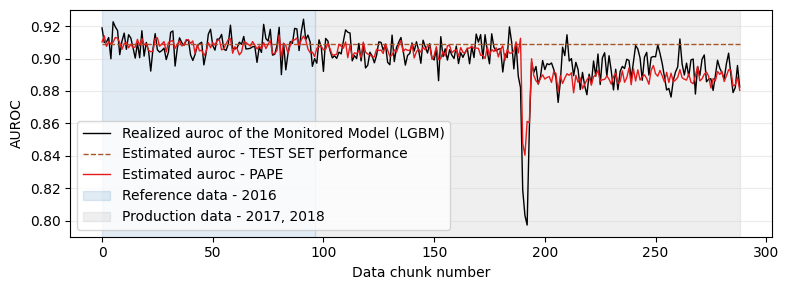

In [51]:
fill_y = [0.75,1]
show_methods = ['TEST_SET', 'PAPE']

plt.figure(figsize=(8,3))
plt.plot(single_method['roc_auc'], label='Realized auroc of the Monitored Model (LGBM)', color='black', linewidth=1)

for method in show_methods:
    method_data = dataset_data[dataset_data['method']==method].reset_index(drop=True)
    
    if method == 'TEST_SET':
        label_val = 'TEST SET performance'
        plt.plot(method_data['est_roc_auc'], '--',label='Estimated auroc - ' + label_val, color = colors[method], linewidth=1)
        ana_data = method_data[method_data['period']=='production']
        MASTE = np.mean(ana_data['AE_' + 'roc_auc']/ana_data['std_' + 'roc_auc'])
        print("MASTE TEST SET:", MASTE) # GET MASTE FOR PAPER
    else:
        label_val = method
        plt.plot(method_data['est_roc_auc'], label='Estimated auroc - ' + label_val, color = colors[method], linewidth=1)
        ana_data = method_data[method_data['period']=='production']
        MASTE = np.mean(ana_data['AE_' + 'roc_auc']/ana_data['std_' + 'roc_auc'])
        print("MASTE PAPE:", MASTE) # GET MASTE FOR PAPER
        

plt.xlabel("Data chunk number")
plt.ylabel('AUROC')
plt.fill_betweenx(fill_y, 0, last_reference_chunk+2, color=CB_color_cycle[0], alpha=0.15, label='Reference data - 2016') #include transition chunks in reference
plt.fill_betweenx(fill_y, first_production_chunk, last_chunk, color=CB_color_cycle[6], alpha=0.15, label='Production data - 2017, 2018')


plt.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
plt.ylim(0.79, .93)
plt.tight_layout()
plt.legend()

plt.savefig('figures/01_example_timeseries.png', dpi=300)

## Rolling by absolute performance change

Calculate metric change and estimated change - Figure 2 from the paper.

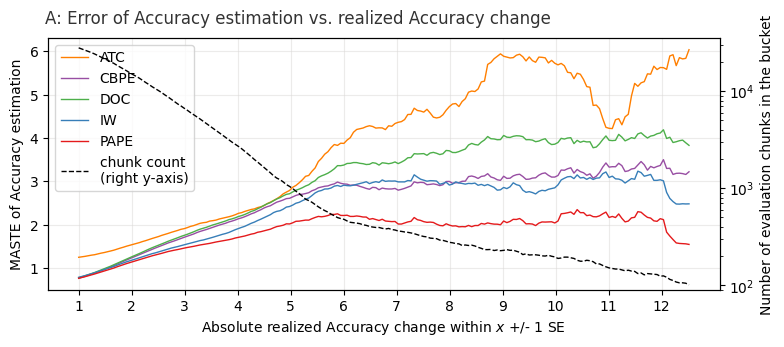

In [52]:
keep = [ 'ATC', 'DOC', 'IW', 'CBPE', 'PAPE'] # TEST SET and RT_mod not included, cause performans bad in comparison and breaks the scale of the plot.

performance_change = 1
metric = 'accuracy'

fig, ax1 = plt.subplots(figsize=(8,3.57))

for i, (method, method_data) in enumerate(dfa.groupby('method', sort=True)):
    if ([x for x in keep if x in method]):
        to_plot = method_data[[metric+'_change', 'std_'+metric, metric+'_est_change']].copy()

        to_plot['x'] = to_plot[metric+'_change']/to_plot['std_'+metric]
        to_plot['y'] = to_plot[metric+'_est_change']/to_plot['std_'+metric]
        to_plot['error'] = to_plot['x'] - to_plot['y']

        MAES, upper, lower = [], [], []
        change_centers = np.linspace(1, 13, 200)
        obs_left = []
        centers_to_plot = []
        for change_center in change_centers:
            minimum_change = change_center - performance_change
            maximum_change = change_center + performance_change
            to_plot_ltd = to_plot[(abs(to_plot['x'])<=maximum_change) & (abs(to_plot['x'])>=minimum_change)]
            if len(to_plot_ltd)<100:
                break
            metric_value = np.mean(abs(to_plot_ltd['error']))
            MAES.append(metric_value)

            obs_left.append(len(to_plot_ltd))
            centers_to_plot.append(change_center)

        ax1.plot(centers_to_plot, MAES, label=method, color=colors[method],  linewidth=1)
            
ax2 = ax1.twinx()
color = 'black'
ax2.plot(centers_to_plot, obs_left, linestyle='--', color=color, label='chunk count\n(right y-axis)', linewidth=1)
ax2.set_ylabel('Number of evaluation chunks in the bucket')  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='black')

ax1.set_xlabel('Absolute realized ' + 'Accuracy' + ' change within $\it{x}$ +/- 1 SE')

ax1.set_ylabel(f"MASTE of Accuracy estimation")
ax2.set_ylim(90, 3.5e4)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)
ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax1.set_xticks(np.arange(1,13))
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax1.text(x=0.07, y=.92, s=f"A: Error of Accuracy estimation vs. realized Accuracy change", 
         transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
plt.tight_layout()
fig.savefig(f'figures/03_rolling_performance_deviation_{metric}.png',dpi=300)

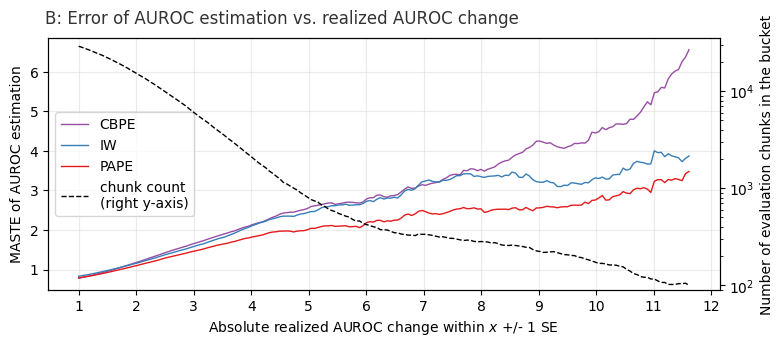

In [53]:
keep = [ 'IW', 'PAPE', 'CBPE']
window=3

performance_change = 1

metric = 'roc_auc'
fig, ax1 = plt.subplots(figsize=(8,3.57))

for i, (method, method_data) in enumerate(dfa.groupby('method', sort=True)):
    if ([x for x in keep if x in method]):
        to_plot = method_data[[metric+'_change', 'std_'+metric, metric+'_est_change']].copy()

        to_plot['x'] = to_plot[metric+'_change']/to_plot['std_'+metric]
        to_plot['y'] = to_plot[metric+'_est_change']/to_plot['std_'+metric]
        to_plot['error'] = to_plot['x'] - to_plot['y']

        MAES, upper, lower = [], [], []
        change_centers = np.linspace(1, 13, 200)
        obs_left = []
        centers_to_plot = []
        for change_center in change_centers:
            minimum_change = change_center - performance_change
            maximum_change = change_center + performance_change
            to_plot_ltd = to_plot[(abs(to_plot['x'])<=maximum_change) & (abs(to_plot['x'])>=minimum_change)]
            if len(to_plot_ltd)<100:
                break
            metric_value = np.mean(abs(to_plot_ltd['error']))
            MAES.append(metric_value)

            obs_left.append(len(to_plot_ltd))
            centers_to_plot.append(change_center)

        ax1.plot(centers_to_plot, MAES, label=method, color=colors[method],  linewidth=1)
            
ax2 = ax1.twinx()
color = 'black'
ax2.plot(centers_to_plot, obs_left, linestyle='--', color=color, label='chunk count\n(right y-axis)', linewidth=1)
ax2.set_ylabel('Number of evaluation chunks in the bucket')  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax1.set_xlabel('Absolute realized AUROC change within $\it{x}$ +/- 1 SE')

ax1.set_ylabel(f"MASTE of AUROC estimation")
ax2.set_ylim(90, 3.5e4)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center left")

ax1.set_xticks(np.arange(1,13))
ax1.set_yticks(np.arange(1,7))
ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax1.text(x=0.07, y=.92, s=f"B: Error of AUROC estimation vs. realized AUROC change", 
         transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
plt.tight_layout()

fig.savefig(f'figures/03_rolling_performance_deviation_{metric}.png',dpi=300)

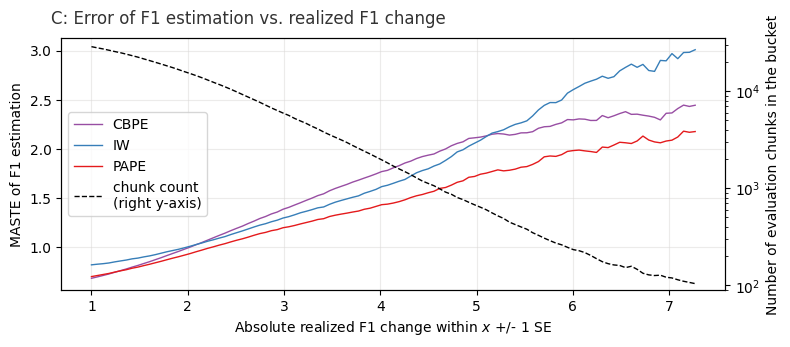

In [54]:
keep = [ 'IW', 'PAPE', 'CBPE']
window=3

performance_change = 1

metric = 'f1'
fig, ax1 = plt.subplots(figsize=(8,3.57))

for i, (method, method_data) in enumerate(dfa.groupby('method', sort=True)):
    if ([x for x in keep if x in method]):
        to_plot = method_data[[metric+'_change', 'std_'+metric, metric+'_est_change']].copy()

        to_plot['x'] = to_plot[metric+'_change']/to_plot['std_'+metric]
        to_plot['y'] = to_plot[metric+'_est_change']/to_plot['std_'+metric]
        to_plot['error'] = to_plot['x'] - to_plot['y']

        MAES, upper, lower = [], [], []
        change_centers = np.linspace(1, 13, 200)
        obs_left = []
        centers_to_plot = []
        for change_center in change_centers:
            minimum_change = change_center - performance_change
            maximum_change = change_center + performance_change
            to_plot_ltd = to_plot[(abs(to_plot['x'])<=maximum_change) & (abs(to_plot['x'])>=minimum_change)]
            if len(to_plot_ltd)<100:
                break
            metric_value = np.mean(abs(to_plot_ltd['error']))
            MAES.append(metric_value)

            obs_left.append(len(to_plot_ltd))
            centers_to_plot.append(change_center)

        ax1.plot(centers_to_plot, MAES, label=method, color=colors[method],  linewidth=1)

ax2 = ax1.twinx()
color = 'black'
ax2.plot(centers_to_plot, obs_left, linestyle='--', color=color, label='chunk count\n(right y-axis)', linewidth=1)
ax2.set_ylabel('Number of evaluation chunks in the bucket', color=color,)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel('Absolute realized F1 change within $\it{x}$ +/- 1 SE')
ax1.set_ylabel(f"MASTE of F1 estimation")
ax2.set_ylim(90, 3.5e4)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center left")

ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax1.text(x=0.07, y=.92, s=f"C: Error of F1 estimation vs. realized F1 change", 
         transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)



plt.tight_layout()

fig.savefig(f'figures/03_rolling_performance_deviation_{metric}.png',dpi=300)